## Is my Spark working?

In [1]:
sc

## Read Input file

Spark can be read data from various data source e.g. RDBMS database, Radis, Cassandra, TextFile, HDFS or even local iterable object.

Let's try text file.

In [138]:
lines = sc.textFile('./small-dataset.tsv')
lines

./small-dataset.tsv MapPartitionsRDD[219] at textFile at NativeMethodAccessorImpl.java:-2

What did I read?

In [3]:
lines.take(5)

['2017-04-11 16:35:24.955238|4.132.3.227|GET|/projects/7490|d35704340a5ca21fa12bcdb99651a1f510ee4dc3| ',
 '2017-04-11 03:50:38.730238|5.191.159.175|GET|/|7c12b22a7d55f9529deab244cdd7eb225dd4b02d| ',
 '2017-04-11 04:25:37.822238|1.139.27.171|GET|/projects/14906|916174bb438772d4d13306c3ed1eb4b3133f83b5| ',
 '2017-04-11 08:12:01.029238|5.161.226.66|GET|/projects/45853/back|87dd42d98bb43aa4f906573ad9aec92224b4adcb| ',
 '2017-04-11 09:17:23.028238|5.161.31.31|GET|/projects/49125|22cc38b17a0fd64567a8dee941866bd49475f204|963359 ']

## Map / Filter

In [16]:
for i in lines.take(5):
    print(i)

2017-04-10 18:20:26.046097|2.17.153.185|GET|/|9752f259fe0a8db86f1edd7d5a06972934d166ae|180921 
2017-04-11 01:33:40.721097|4.57.103.71|GET|/|8961cde5716869388e6529e9755a4d69090e7d8c|466503 
2017-04-11 13:34:23.421097|5.42.151.183|GET|/projects/20112|2171ba8e62627d1a4b5e177d8ad17c77f04d2452| 
2017-04-10 16:18:01.028097|4.103.153.153|GET|/projects/11248|3634c853d04492efbe69a92b286f340d0c996eb4|803993 
2017-04-11 09:00:57.153097|2.161.102.38|GET|/projects/29258|9bd18f8a22c520623da5e58a1511cd51fe63f2b6| 


In [14]:
lines.foreach(print)

In [139]:
from collections import namedtuple
import datetime as dt

AccessLog = namedtuple('AccessLog', ['ip_address', 'path', 'method', 'timestamp', 'session_id', 'member_id'])

def parse_log(log_str):
    spiltted = log_str.split('|')
    return AccessLog(
        timestamp=dt.datetime.strptime(spiltted[0], '%Y-%m-%d %H:%M:%S.%f'),
        ip_address=parse_ip_addr(spiltted[1]),
        method=spiltted[2],
        path=spiltted[3],
        session_id=spiltted[4],
        member_id=spiltted[5]
    )

In [140]:
logs = lines.map(parse_log)

In [19]:
ll = logs.take(10000)

In [5]:
get_logs = logs.filter(lambda log: log.method == 'GET')

In [141]:
view_count = get_logs.map(lambda _: 1).reduce(lambda acc, i: acc + i)
view_count

1452849

In [142]:
session_count = get_logs.groupBy(lambda log: log.session_id).map(lambda _: 1).reduce(lambda acc, i: acc + i)
session_count

765300

In [8]:
session_count = get_logs.keyBy(lambda log: log.session_id)\
                        .mapValues(lambda _: 1)\
                        .reduceByKey(lambda acc, i: 1)\
                        .map(lambda t: t[1])\
                        .reduce(lambda acc, i: acc + i)
        
session_count

765300

In [9]:
req_per_session = get_logs.keyBy(lambda log: log.session_id)\
                        .mapValues(lambda _: 1)\
                        .reduceByKey(lambda acc, i: acc + i)

req_per_session = req_per_session.persist()

In [13]:
view_count = req_per_session.map(lambda t: t[1]).reduce(lambda acc, i: acc + i)
view_count

1452849

In [11]:
session_count = req_per_session.map(lambda _: 1).reduce(lambda acc, i: acc + i)
session_count

765300

In [12]:
sum_square = req_per_session.map(lambda t: t[1] ** 2)\
                     .reduce(lambda acc, i: acc + i)
sum_square

3569227

In [21]:
average = view_count / session_count
average

1.898404547236378

In [22]:
variance = (sum_square / session_count) - (average ** 2)
variance

1.0598874323169674

# A Job has fixed cost

In [137]:
AccumulateData = namedtuple('AccumulateData', ['n', 'sum', 'sum_square'])

ZERO_ACC = AccumulateData(0, 0, 0)

def acc_stat(acc, new_val):
    return AccumulateData(
        n=acc.n + 1,
        sum=acc.sum + new_val,
        sum_square=acc.sum_square + new_val ** 2
    )

In [15]:
acc_stat(acc_stat(acc_stat(ZERO_ACC, 1), 3), 7)

AccumulateData(n=3, sum=11, sum_square=59)

In [16]:
def combined_stat(acc1, acc2):
    return AccumulateData(
        n=acc1.n + acc2.n,
        sum=acc1.sum + acc2.sum,
        sum_square=acc1.sum_square + acc2.sum_square
    )

In [17]:
acc1 = acc_stat(acc_stat(ZERO_ACC, 1), 3)
acc2 = acc_stat(ZERO_ACC, 7)

combined_stat(acc1, acc2)

AccumulateData(n=3, sum=11, sum_square=59)

In [18]:
def finalize_acc_stat(acc):
    return {
        'average': acc.sum / acc.n,
        'variance': (acc.sum_square / acc.n) - (acc.sum / acc.n) ** 2
    }

finalize_acc_stat(AccumulateData(n=session_count, sum=view_count, sum_square=sum_square))

{'average': 1.898404547236378, 'variance': 1.0598874323169674}

In [19]:
acc_val = req_per_session.map(lambda t: t[1])\
                         .aggregate(ZERO_ACC, acc_stat, combined_stat)
acc_val

AccumulateData(n=765300, sum=1452849, sum_square=3569227)

In [20]:
finalize_acc_stat(acc_val)

{'average': 1.898404547236378, 'variance': 1.0598874323169674}

## More realistic example

In [23]:
import re

patterns = (
    (re.compile(r'(/$)'), 'GET', 'LANDING'),
    (re.compile(r'/projects/(\d+)(/?)$'), 'GET', 'VIEW PRODUCT'),
    (re.compile(r'/projects/(\d+)/back(/?)$'), 'GET', 'READY TO BACK'),
    (re.compile(r'/projects/(\d+)/back(/?)$'), 'POST', 'BACKED')
)

def get_action(log):
    for pattern in patterns:
        if pattern[0].match(log.path) and log.method == pattern[1]:
            return pattern[2]
    return 'UNKNOWN'

In [26]:
count_by_action = (
    logs.keyBy(get_action)
        .mapValues(lambda _: 1)
        .reduceByKey(lambda acc, i: acc + i)
        .collect()
)
count_by_action

[('UNKNOWN', 56728),
 ('LANDING', 709462),
 ('READY TO BACK', 70787),
 ('BACKED', 7070),
 ('VIEW PRODUCT', 637371)]

In [30]:
count_by_action = sorted(
    filter(lambda item: item[0] != 'UNKNOWN', count_by_action),
    key=lambda item: item[1],
    reverse=True
)

count_by_action

[('LANDING', 709462),
 ('VIEW PRODUCT', 637371),
 ('READY TO BACK', 70787),
 ('BACKED', 7070)]

In [68]:
%matplotlib notebook
%run 'util.py'

In [32]:
help(plot_bar)

Help on function plot_bar in module __main__:

plot_bar(label, data)
    Plot a bar graph with one serie.
    param label: list of label (any type)
    param data: list of data (number only). Its length should be match with label



<IPython.core.display.Javascript object>


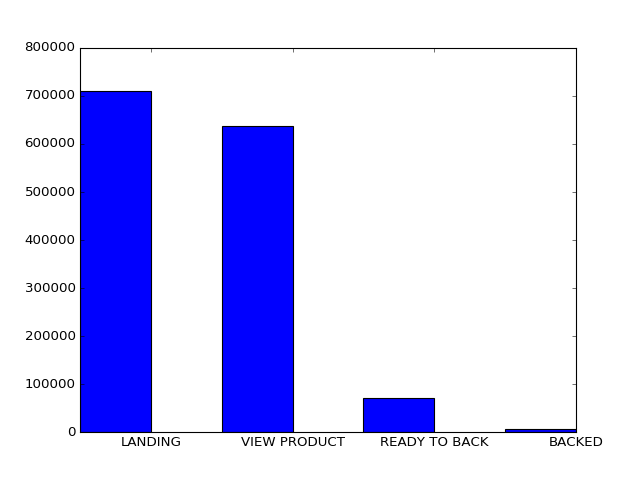

In [33]:
plot_bar(
    list(map(lambda item: item[0], count_by_action)), 
    list(map(lambda item: item[1], count_by_action))
)

In [41]:
ACTION_ORDINAL = {'LANDING': 1, 'VIEW PRODUCT': 2, 'READY TO BACK': 3, 'BACKED': 4}

result = logs.keyBy(lambda log: (log.timestamp.date(), get_action(log)))\
    .mapValues(lambda _: 1)\
    .reduceByKey(lambda acc, i: acc + i)\
    .filter(lambda item: item[0][1] != 'UNKNOWN')\
    .sortBy(lambda item: (item[0][0], ACTION_ORDINAL[item[0][1]]))\
    .collect()

[32448, 126584, 108143, 108887, 81914, 84393, 89665, 77428] range(0, 8)


<IPython.core.display.Javascript object>


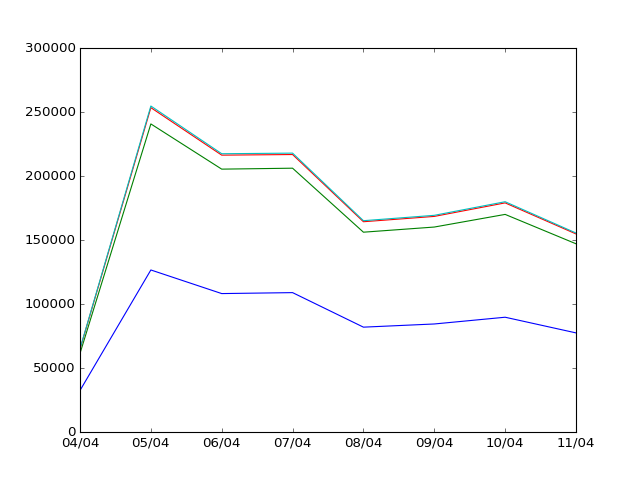

[61430, 240680, 205363, 206097, 156099, 160122, 169998, 147044] range(0, 8)
[64714, 253403, 216298, 216771, 164272, 168430, 178998, 154734] range(0, 8)
[65041, 254675, 217393, 217869, 165083, 169278, 179904, 155447] range(0, 8)


In [64]:
label = [item[0][0].strftime('%d/%m') for item in result[0:len(result):4]]
data = [[item[1] for item in result[i:len(result):4]]
        for i in range(4)]
stack_line(label, data)

## Multiple DataSource

In [102]:
geo_ips = sc.textFile('GeoIPOriginal.csv')
geo_ips.take(1)

['1.0.0.0,1.0.0.255,Australia']

In [103]:
GeoIPOriginal = namedtuple('GeoIPOriginal', ['start', 'stop', 'country'])

def parse_geo_ip_record(text):
    splitted = text.split(',')
    return GeoIPOriginal(
        parse_ip_addr(splitted[0]),
        parse_ip_addr(splitted[1]),
        splitted[2]
    )

In [89]:
sample_ip = geo_ips.map(parse_geo_ip_record).take(5)
sample_ip

[GeoIPOriginal(start=(1, 0, 0, 0), stop=(1, 0, 0, 255), country='Australia'),
 GeoIPOriginal(start=(1, 0, 1, 0), stop=(1, 0, 3, 255), country='China'),
 GeoIPOriginal(start=(1, 0, 4, 0), stop=(1, 0, 7, 255), country='Australia'),
 GeoIPOriginal(start=(1, 0, 8, 0), stop=(1, 0, 15, 255), country='China'),
 GeoIPOriginal(start=(1, 0, 16, 0), stop=(1, 0, 31, 255), country='Japan')]

In [90]:
split_range_to_class_c(sample_ip[2].start, sample_ip[2].stop)

[(1, 0, 4, 0), (1, 0, 5, 0), (1, 0, 6, 0), (1, 0, 7, 0)]

In [91]:
def split_ip_ranges(ip_original):
    sub_ips = split_range_to_class_c(ip_original.start, ip_original.stop)
    return [
        (ip, ip_original.country)
        for ip in sub_ips
    ]

In [105]:
geo_ips.map(parse_geo_ip_record).flatMap(split_ip_ranges).take(5)

[((1, 0, 0, 0), 'Australia'),
 ((1, 0, 1, 0), 'China'),
 ((1, 0, 2, 0), 'China'),
 ((1, 0, 3, 0), 'China'),
 ((1, 0, 4, 0), 'Australia')]

In [106]:
geo_ips = geo_ips.map(parse_geo_ip_record)\
                 .flatMap(split_ip_ranges)

In [114]:
geo_logs = logs.keyBy(lambda log: mask_to_class_c(log.ip_address))\
               .join(geo_ips)
geo_logs.take(1)

[((4, 106, 187, 0),
  (AccessLog(ip_address=(4, 106, 187, 147), path='/', method='GET', timestamp=datetime.datetime(2017, 4, 10, 14, 19, 17, 260432), session_id='1281499df8a52766f477c3f3bcb754620534f55f', member_id=' '),
   'United States'))]

In [121]:
top_countries = geo_logs.map(lambda item: (item[1][1], 1))\
                        .reduceByKey(lambda acc, i: acc + i)\
                        .top(10, lambda item: item[1])

In [122]:
top_countries

[('United States', 589512),
 ('China', 88963),
 ('"Iran', 86533),
 ('"Korea', 82882),
 ('Italy', 81870),
 ('Germany', 62250),
 ('United Kingdom', 57795),
 ('Australia', 53897),
 ('Russian Federation', 45472),
 ('France', 26063)]

## Structured Data - DataFrame

In [123]:
spark

In [127]:
spark.read.csv('small-dataset.tsv', sep='|', )

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string]

In [129]:
log_df = spark.read.csv('small-dataset.tsv', sep='|', )\
              .withColumnRenamed('_c4', 'session')
log_df.show()

+--------------------+-------------+---+--------------------+--------------------+-------+
|                 _c0|          _c1|_c2|                 _c3|             session|    _c5|
+--------------------+-------------+---+--------------------+--------------------+-------+
|2017-04-10 23:28:...| 2.255.98.242|GET|                   /|5f371127bb18d8a05...|       |
|2017-04-11 10:16:...|3.209.247.231|GET|                   /|f2c5b13e8a04413bc...|       |
|2017-04-11 08:25:...| 1.130.16.240|GET|     /projects/37002|eca3bc1ed5b93a8d7...|       |
|2017-04-10 21:48:...|  1.248.32.48|GET|                   /|a5937f00512070f66...|       |
|2017-04-11 07:27:...| 5.35.186.186|GET|      /projects/2353|735fd39364733d490...|643514 |
|2017-04-10 19:21:...|   4.3.241.97|GET|     /projects/29417|e12529adfc4982977...|717153 |
|2017-04-11 14:01:...|  4.120.96.16|GET|                   /|b1bc88fca1702ff32...|       |
|2017-04-11 05:08:...|5.146.187.107|GET|     /projects/12298|08b6de69831e065bd...|       |

In [143]:
req_per_session_df = log_df.where(log_df['_c2'] != 'POST')\
                           .groupBy(log_df['session'])\
                           .count().withColumnRenamed('count', 'request_count')

In [153]:
import pyspark.sql.functions as sql_func

req_per_session_df.select(
    sql_func.avg(req_per_session_df['request_count']).alias('avg'), 
    sql_func.variance(req_per_session_df['request_count']).alias('variance')
).show()

+-----------------+------------------+
|              avg|          variance|
+-----------------+------------------+
|1.898404547236378|1.0598888172494352|
+-----------------+------------------+



In [152]:
req_per_session_df.createTempView('RequestPerSession')

spark.sql('SELECT avg(request_count) as avg, variance(request_count) as variance FROM RequestPerSession').show()

+-----------------+------------------+
|              avg|          variance|
+-----------------+------------------+
|1.898404547236378|1.0598888172494352|
+-----------------+------------------+

